Импорты и функции

In [23]:
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

import sys
sys.path.insert(0, 'tokens')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')

In [24]:
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
SAMPLE_SPREADSHEET_ID = '1smzXne9dbQzItRJImMmWNz_JIFm9a469nPhBu5D_36I'
SAMPLE_RANGE_NAME = 'A:F'


def parse_series(spreadsheet_id=SAMPLE_SPREADSHEET_ID, spreadsheet_range=SAMPLE_RANGE_NAME):
    creds = None

    if os.path.exists('tokens/token.json'):
        creds = Credentials.from_authorized_user_file('tokens/token.json', SCOPES)
    if not creds or not creds.valid:
        with open('tokens/token.json', 'w') as token:
            token.write(creds.to_json())

    try:
        service = build('sheets', 'v4', credentials=creds)

        # Call the Sheets API
        sheet = service.spreadsheets()
        result = sheet.values().get(spreadsheetId=spreadsheet_id,
                                    range=spreadsheet_range).execute()
        values = result.get('values', [])

        return values

    except HttpError as err:
        print(err)
        return []

Импорт статистики по всем банерам и её аугментация

In [25]:
raw_data = pd.DataFrame(parse_series())
raw_data.columns = raw_data.iloc[0]
raw_data = raw_data.drop(raw_data.index[0])

raw_data.head(3)

,platform,campaign_id,campaign_name,date,impressions,clicks
1,yandex direct,75993195,Венарус | Фармацевты | Баннеры | База Брефи,4/23/2023,35423,109
2,yandex direct,79820654,Дексонал | Фармацевты | Баннеры | База Брефи,4/23/2023,13654,159
3,yandex direct,82468420,Венарус | Фармацевты | Баннеры | База БФГ,4/23/2023,20100,58


In [26]:
typed_data = raw_data
typed_data.loc[:, 'date'] = pd.to_datetime(typed_data['date'], format='%m/%d/%Y')
typed_data['campaign_id'] = pd.to_numeric(typed_data['campaign_id'], errors='coerce').fillna(0)
typed_data['impressions'] = pd.to_numeric(typed_data['impressions'], errors='coerce').fillna(0)
typed_data['clicks'] = pd.to_numeric(typed_data['clicks'], errors='coerce').fillna(0)

typed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92061 entries, 1 to 92061
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   platform       92061 non-null  object
 1   campaign_id    92061 non-null  int64 
 2   campaign_name  92061 non-null  object
 3   date           92061 non-null  object
 4   impressions    92061 non-null  int64 
 5   clicks         92061 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 4.2+ MB


Выделение статистики отдельного банера по названию рекламной компании

In [32]:
unique_names = typed_data['campaign_name'].unique()

unique_names

array(['Венарус | Фармацевты | Баннеры | База Брефи',
       'Дексонал | Фармацевты | Баннеры | База Брефи',
       'Венарус | Фармацевты | Баннеры | База БФГ',
       'Дексонал | Фармацевты | Баннеры | База БФГ',
       'ВА036 | Венарус, Венапрокт | Хирурги, проктологи, колопроктологи | Баннеры | База Брефи',
       'ВА036 | Венарус, Венапрокт | Сосудистые хирурги, флебологи | Баннеры | База Брефи',
       'Максилак | Педиатры | Баннеры | База БФГ',
       'Максилак | Педиатры | Баннеры | База Бреффи',
       'ЕВ040_Акнауцер | Фармацевты | Баннеры | База БФГ',
       'ЕВ040_Акнауцер | Фармацевты | Баннеры | База Breffi',
       'СВ001 | Необутин | Гастро | Баннеры gif | База БФГ',
       'СВ001 | Необутин | Гастро | Баннеры gif | База Breffi',
       'Необутин | Гастро | Баннеры | База Брефи',
       'Кагоцел | Фармацевты | Баннеры | База Брефи',
       'Диклофенак-Акос | Терапевты | Баннеры | База Брефи',
       'Дексонал  | Терапевты | Баннеры | База Брефи',
       'Диклофенак-Акос 

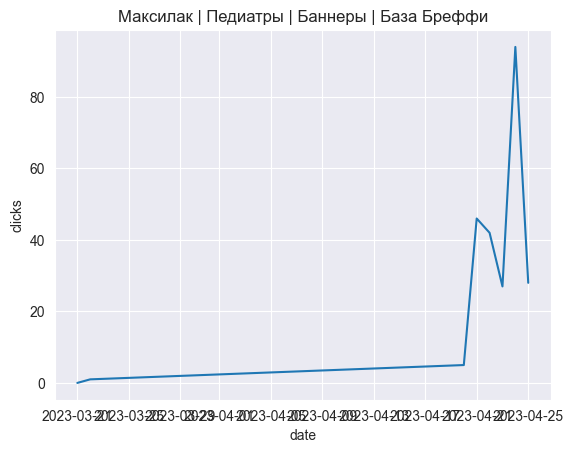

In [36]:
#Здесь можно указать имя нужной нам рекламной компании
#При необходимости можно группировать не по именам, а по  id
target_name = unique_names[7]
target_name_data = typed_data.groupby(['campaign_name']).get_group(target_name)
target_name_data = target_name_data.sort_values(by='date')

# target_name_data

target_stat = 'clicks'

# Выведем график нужной нам статистики
sns.lineplot(data=target_name_data, x='date', y=target_stat)
plt.xlabel('date')
plt.ylabel(f'{target_stat}')
plt.title(f'{target_name}')

plt.show()